# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import Data

# Sales and profit data for a 

In [2]:
df = pd.read_excel("/Users/dominguez/Documents/anomaly_detection/data/Superstore.xls")

- Data contains transaction data for a global superstore. We will focus on 'Sales' and 'Profit' for our analysis

# Univariate

## Sales

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [5]:
# No nulls!

In [6]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### EDA

In [7]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


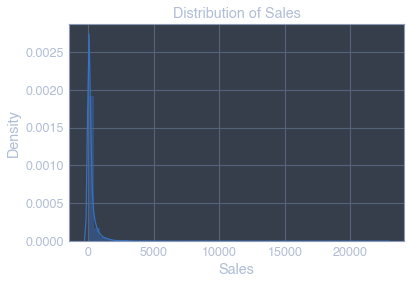

In [8]:
# Distribution of Sales
sns.distplot(df['Sales'])
plt.title("Distribution of Sales");

- Anomalies definitely exist to the right

In [9]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


- Skewness determines the symmetry of the distribution.
    - $ skewness = \frac{\sum_{i=1}^{n} (X_i-\hat{X_i})^3}{(n-1)(\theta^3)} $
- Kurtosis refers to the pointedness of a peak of a distrbution. 
    - $ kurtosis= n * \frac{\sum_{i=1}^{n} (X_i-\hat{X_i})^4}{\sum_{i=1}^{n} (X_i-\hat{X_i^2})^2} $

![](skewness-kurtosis.jpg)

### Anomaly Detection

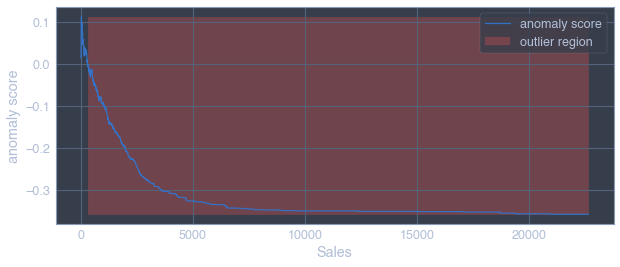

In [10]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))

# Store Sales data in a numpy array
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)

# Assign anomaly scores to every data point
anomaly_score = isolation_forest.decision_function(xx)

# Detemine outliers, array of (-1 for not outlier and 1 for outlier)
outlier = isolation_forest.predict(xx)

# Plot outlier region with anomaly scores
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

Any sale transaction above around ~$500 is considered a statistical anomaly

In [11]:
# What percentage is anomalous

print(f"Percentage of data that is anomalous: {round(len(df[df['Sales'] > 1000])/len(df),4) * 100}%")

Percentage of data that is anomalous: 4.68%


## Profit

### EDA

In [12]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


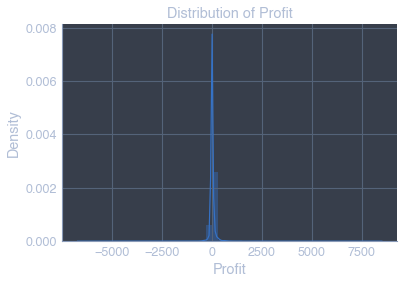

In [13]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

Strong positive kurtosis, little/no skewness

In [14]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


### Anomaly Detection

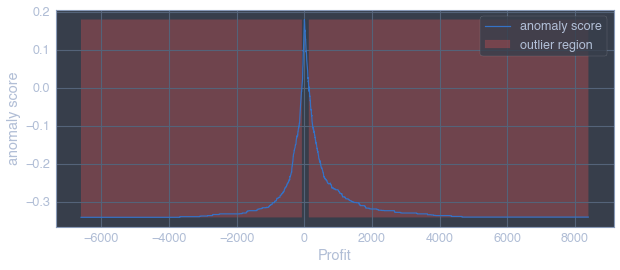

In [15]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))

# Store Sales data in a numpy array
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)

# Assign anomaly scores to every data point
anomaly_score = isolation_forest.decision_function(xx)

# Detemine outliers
outlier = isolation_forest.predict(xx)

# Plot outlier region with anomaly scores
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

In [16]:
# What percentage is anomalous

print(f"Percentage of data that is anomalous: {round(len(df[(df['Profit'] > 100) | (df['Profit'] < -10)])/len(df),4) * 100}%")

Percentage of data that is anomalous: 21.07%


In [17]:
# Conclusion: Any negative profit should be investigated
# Univariate anomaly detection can only get us so far

# Multivariate

## Anomaly Detection for Sales and Profit

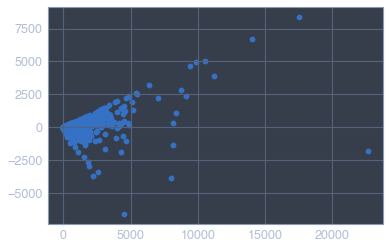

In [18]:
plt.scatter(df['Sales'], df['Profit']);

In [19]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = scaler.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [20]:
# Convert to numpy arrays and concancenate the data a
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [21]:
def model(classifier_n):
    
    outliers_fraction = 0.01
    random_state = 42

    classifiers = {
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
    }

    xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    clf_name = list(classifiers.keys())[classifier_n]
    clf = list(classifiers.values())[classifier_n]
    clf.fit(X)
    scores_pred = clf.decision_function(X) * -1
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)

    plt.figure(figsize=(8, 8))

    df1 = df
    df1['outlier'] = y_pred.tolist()

    # sales - inlier feature 1,  profit - inlier feature 2
    inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
    inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)

    # sales - outlier feature 1, profit - outlier feature 2
    outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
    outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)

    print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
    threshold = np.percentile(scores_pred, 100 * outliers_fraction)        
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')

    c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')

    plt.axis('tight')   
    plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
               prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right') 
    plt.xlabel('Sales (Scaled)')
    plt.ylabel('Profit (Scaled)')
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show();
    
    # Print outliers
    print("First 5 Outliers")
    outlier_dict = {'Outlier_Sales': np.array(df1['Sales'][df1['outlier'] == 1]), 
                    'Outlier_Profit': np.array(df1['Profit'][df1['outlier'] == 1])
                   }
    df_o = pd.DataFrame(outlier_dict)
    df_o[['Outlier_Sales','Outlier_Profit']] = scaler.inverse_transform(df_o[['Outlier_Sales','Outlier_Profit']])
    #df_o[['Outlier_Sales','Outlier_Profit']].head()
    print(df_o.head())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


OUTLIERS: 100 INLIERS: 9894


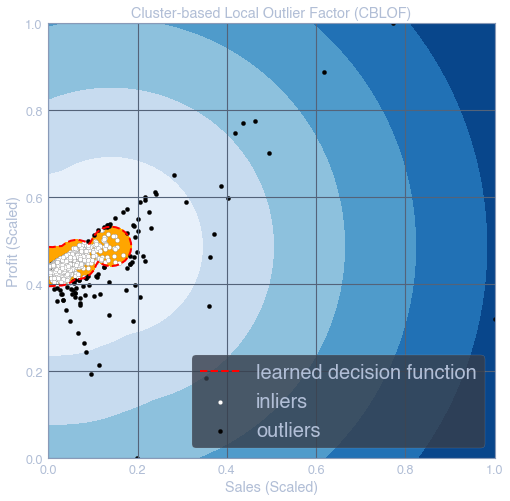

First 5 Outliers
   Outlier_Sales  Outlier_Profit
0       3083.430      -1665.0522
1       8159.952      -1359.9920
2       1188.000       -950.4000
3       3059.982       -509.9970
4       2519.958       -251.9958


In [22]:
model(0)

OUTLIERS: 100 INLIERS: 9894


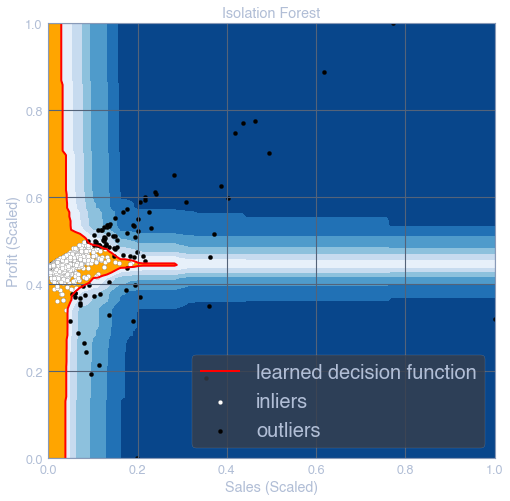

First 5 Outliers
   Outlier_Sales  Outlier_Profit
0       3083.430      -1665.0522
1       8159.952      -1359.9920
2       1188.000       -950.4000
3       3347.370        636.0003
4       3059.982       -509.9970


In [23]:
model(1)

OUTLIERS: 91 INLIERS: 9903


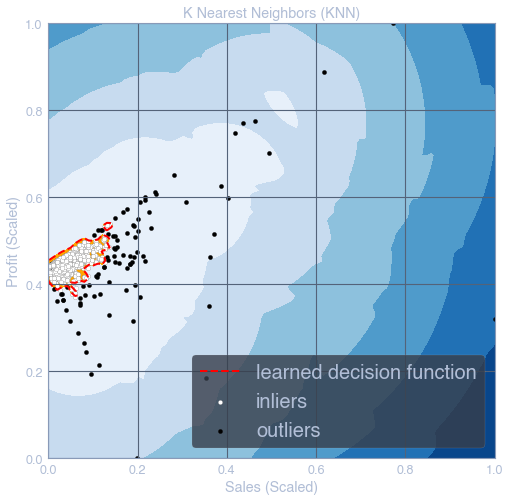

First 5 Outliers
   Outlier_Sales  Outlier_Profit
0       3083.430      -1665.0522
1       8159.952      -1359.9920
2       3347.370        636.0003
3       3059.982       -509.9970
4       2519.958       -251.9958


In [24]:
model(2)